In [20]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [21]:
# Paths
image_dir = 'dataset/images'
csv_file = 'dataset/HAM10000_metadata.csv'
output_dir = 'output'

df = pd.read_csv('dataset/HAM10000_metadata.csv')

label_mapping = {
    'bkl': 0,   # Benign
    'df': 0,    # Benign
    'nv': 0,    # Benign
    'vasc': 0,  # Benign
    'mel': 1,   # Malignant
    'bcc': 1,   # Malignant
    'akiec': 1  # Malignant
}
df['label'] = df['dx'].map(label_mapping)

In [22]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Create directories
for split in ['train', 'test']:
    for label in ['benign', 'malignant']:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Move files based on labels
for split_df, split in [(train_df, 'train'), (test_df, 'test')]:
    for _, row in split_df.iterrows():
        label = 'benign' if row['label'] == 0 else 'malignant'
        src = os.path.join(image_dir, row['image_id'] + '.jpg')
        dst = os.path.join(output_dir, split, label, row['image_id'] + '.jpg')
        shutil.copy(src, dst)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale only for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    'output/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'output/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 8012 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\Parth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

c:\Users\Parth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.7877 - loss: 0.4963 - val_accuracy: 0.8048 - val_loss: 0.6917
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 250ms/step - accuracy: 0.8125 - loss: 0.4539 - val_accuracy: 0.8048 - val_loss: 0.4388
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.8032 - loss: 0.4313 - val_accuracy: 0.8048 - val_loss: 0.4180
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 253ms/step - accuracy: 0.8028 - loss: 0.4194 - val_accuracy: 0.8048 - val_loss: 0.4087
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 64s 254ms/step - accuracy: 0.8084 - loss: 0.3952 - val_accuracy: 0.8048 - val_loss: 0.4053
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - accuracy: 0.8068 - loss: 0.3965 - val_accuracy: 0.8048 - val_loss: 0.3997
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 248ms/step - accuracy: 0.8063 - loss: 0.3979 - val_accuracy: 0.8078 - val_loss: 0.3929
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 63s 253ms/step - accuracy: 0.8079 - loss: 0.3

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.8250 - loss: 0.3537
Test Accuracy: 82.68%
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step


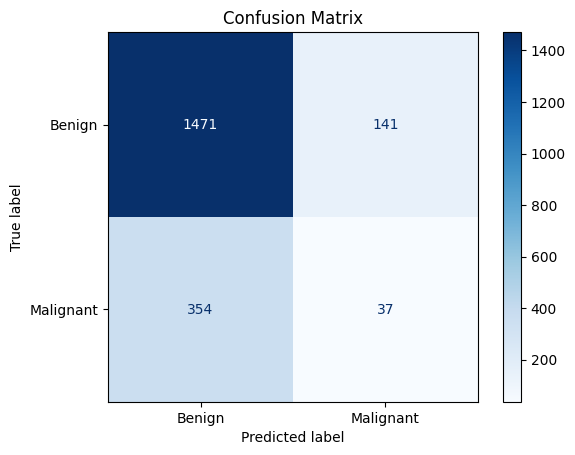

              precision    recall  f1-score      support
Benign         0.806027  0.912531  0.855979  1612.000000
Malignant      0.207865  0.094629  0.130053   391.000000
accuracy       0.752871  0.752871  0.752871     0.752871
macro avg      0.506946  0.503580  0.493016  2003.000000
weighted avg   0.689262  0.752871  0.714273  2003.000000


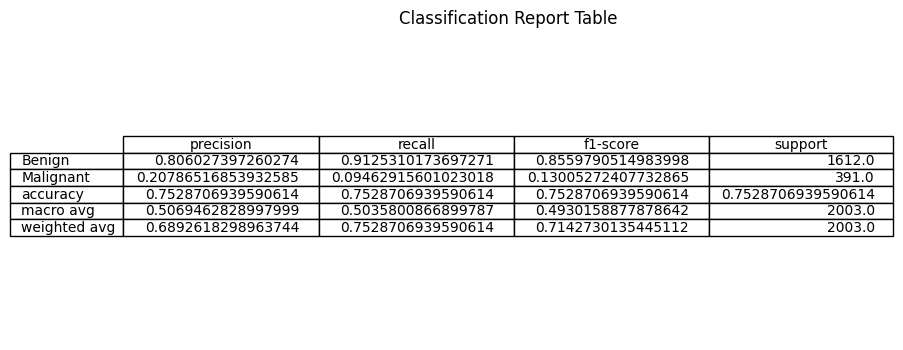

In [28]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()
    
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
#plt.savefig("confusion_matrix.png")
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'], output_dict=True)

# Display as a table
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)

# Save the classification report as a CSV for additional use
report_df.to_csv("classification_report.csv")

# Plotting the table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=report_df.values, colLabels=report_df.columns, rowLabels=report_df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(report_df.columns))))
plt.title("Classification Report Table")
#plt.savefig("classification_report_table.png")
plt.show()

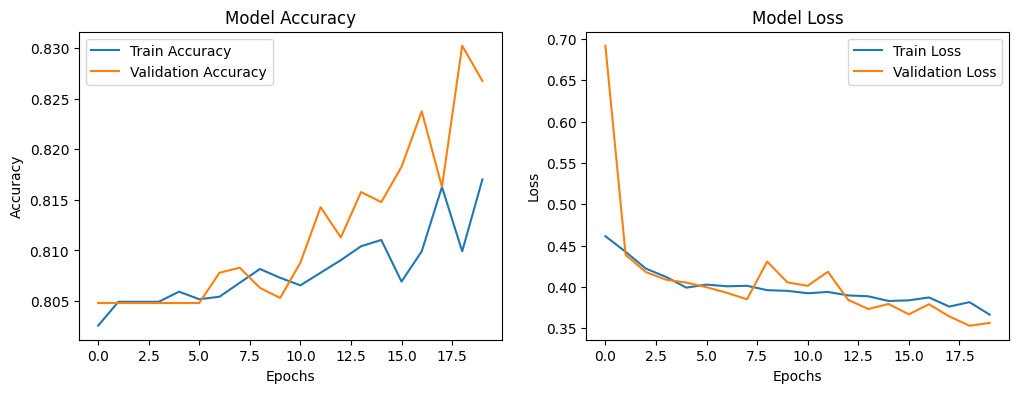

In [29]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
# Save the model
model.save('melanoma_cnn_model.h5')

In [31]:
# Load the model later
from tensorflow.keras.models import load_model
loaded_model = load_model('melanoma_cnn_model.h5')

In [32]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return "Malignant" if prediction > 0.5 else "Benign"

result = predict_image('dataset/images/ISIC_0024306.jpg', loaded_model)
print(f"Prediction: {result}")  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction: Benign
